In [1]:
#transformer model packages
import time
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import random

#visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

#censoring model packages


### Sentence Embedding Visualization

In [2]:
dataframe = pd.concat(
    [
        pd.read_csv("data/hateval/hateval2019_en_train.csv"),
        pd.read_csv("data/hateval/hateval2019_en_dev.csv"),
        pd.read_csv("data/hateval/hateval2019_en_test.csv"),
    ],
    keys=["train", "dev", "test"],
    names=["split", "index"],
)

datasets = DatasetDict(
    {
        split: Dataset.from_pandas(dataframe.loc[(split)])
        for split in ["train", "dev", "test"]
    }
)
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'HS', 'TR', 'AG', 'index'],
        num_rows: 9000
    })
    dev: Dataset({
        features: ['id', 'text', 'HS', 'TR', 'AG', 'index'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'text', 'HS', 'TR', 'AG', 'index'],
        num_rows: 3000
    })
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "ChrisZeng/bertweet-base-cased-covid19-hateval"
)
model = AutoModelForSequenceClassification.from_pretrained(
    "ChrisZeng/bertweet-base-cased-covid19-hateval"
)

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji


In [4]:
def indice2logits(indice, num_classes):
    indice = np.array(indice)
    logits = np.zeros([len(indice), num_classes], dtype=float)
    logits[np.arange(len(indice)), indice] = 1.0
    return {"label_logits": logits}


datasets = datasets.map(
    lambda rec: tokenizer(
        rec["text"],
        padding="max_length",
        max_length=192,
        pad_to_multiple_of=8,
        return_token_type_ids=True,
        return_attention_mask=True,
    ),
    batched=True,
    keep_in_memory=True,
    batch_size=128,
)

datasets = datasets.map(
    lambda rec: indice2logits(rec["HS"], 2),
    batched=True,
    keep_in_memory=True,
)

datasets = datasets.rename_column("label_logits", "labels")
datasets = datasets.remove_columns([])
datasets

  0%|          | 0/71 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'HS', 'TR', 'AG', 'index', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9000
    })
    dev: Dataset({
        features: ['id', 'text', 'HS', 'TR', 'AG', 'index', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'text', 'HS', 'TR', 'AG', 'index', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
})

In [62]:
#sample 200 training samples and 50 test samples for visualization
random.seed(3)
train_ids = random.sample(range(0,9000), 200)
test_ids = random.sample(range(0,3000), 100)

In [63]:
#get hidden state
train_tokens = tokenizer(datasets["train"][train_ids]["text"], padding="max_length", max_length=128, return_tensors="pt", truncation=True)
train_output = model(input_ids=train_tokens["input_ids"], attention_mask=train_tokens["attention_mask"], output_hidden_states=True)

test_tokens = tokenizer(datasets["test"][test_ids]["text"], padding="max_length", max_length=128, return_tensors="pt", truncation=True)
test_output = model(input_ids=test_tokens["input_ids"], attention_mask=test_tokens["attention_mask"], output_hidden_states=True)

In [64]:
def cal_sentence_embedding(hs):
    #mean pooling
    return torch.mean(hs, 1)

In [93]:
train_emb = cal_sentence_embedding(train_output['hidden_states'][-1]).detach().numpy()
test_emb = cal_sentence_embedding(test_output['hidden_states'][-1]).detach().numpy()

concat = np.concatenate((train_emb, test_emb), axis=0)

tsne = TSNE(n_components=2, perplexity=16, random_state=42)
tsne_result = tsne.fit_transform(concat)

df = pd.DataFrame()
df['tsne_component_1'] = tsne_result[:,0]
df['tsne_component_2'] = tsne_result[:,1]

In [94]:
sample_labels = [l for l in datasets["train"][train_ids]["HS"]] + [l+2 for l in datasets["test"][test_ids]["HS"]]
df["labels"] = sample_labels

def rename_labels(l):
    if l == 0:
        return "hateval_train_not_HS"
    elif l == 1:
        return "hateval_train_HS"
    elif l == 2:
        return "hateval_test_not_HS"
    else:
        return "hateval_test_HS"
    
df["labels"] = df["labels"].apply(rename_labels)

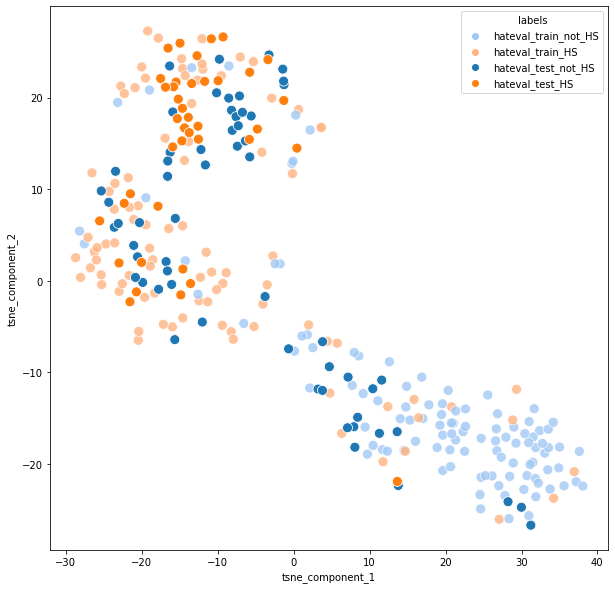

In [95]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='tsne_component_1', y='tsne_component_2', data=df[:200],  hue='labels',
                palette=sns.color_palette("pastel",2), legend="full", alpha=0.8, s=100)

sns.scatterplot(x='tsne_component_1', y='tsne_component_2', data=df[200:],  hue='labels',
                palette=sns.color_palette("tab10",2), legend="full", alpha=1, s=100)

In [107]:
#test the same model on a different dataset
#source: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/
jigsaw_text = pd.read_csv("data/jigsaw/test.csv")
jigsaw_label = pd.read_csv("data/jigsaw/test_labels.csv")

In [110]:
jigsaw = pd.merge(jigsaw_text, jigsaw_label, on="id")

In [112]:
jigsaw = jigsaw[jigsaw["toxic"]!=-1]

In [218]:
def clean_text(text):
    return text.replace("\n", " ").replace("=", "")

jigsaw["comment_text"] = jigsaw["comment_text"].apply(clean_text)

jigsaw

<ipython-input-218-1ea8a1f934b5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jigsaw["comment_text"] = jigsaw["comment_text"].apply(clean_text)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" It says it right there that it IS a type....",0,0,0,0,0,0
14,00059ace3e3e9a53,""" Before adding a new product to the list,...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,Lucky bastard http://wikimediafoundation.org...,0,0,0,0,0,0
153154,fffa8a11c4378854,shame on you all!!! You want to speak about...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [229]:
jigsaw_sample = pd.concat([jigsaw[jigsaw["toxic"]==0].sample(50), jigsaw[jigsaw["toxic"]==1].sample(50)])
jigsaw_sample

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
28553,2f8ce9a6f37c8737,How about a marketing fad category? is th...,0,0,0,0,0,0
74844,7cc1daf5979171c3,"""Welcome! Hello, , and welcome to Wikipedia...",0,0,0,0,0,0
118244,c55fccf9eb41bf23,":To be honest, it's a subject that I'm almost ...",0,0,0,0,0,0
3400,05d825d9be83790c,"Swaminarayan Page Hi, I deleted the link bec...",0,0,0,0,0,0
51204,54f60894a4e2076b,""" :If this isn't a controversial topic, the...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
6567,0b076bfd90c3686a,You're a fucking idiot,1,1,1,0,1,0
11832,13d3428ea00cbcb0,::::I've crossed the line myself before. You h...,1,0,1,0,0,0
8206,0dc1e6b780580626,""" Fuck it, this conversation is as likely to ...",1,0,1,0,1,0
61409,66303e58b245125b,*This is a ridiculous claim. How does listing ...,1,0,0,0,0,0


In [246]:
jigsaw_tokens = tokenizer(list(jigsaw_sample["comment_text"]), padding="max_length", max_length=128, return_tensors="pt", truncation=True)
jigsaw_output = model(input_ids=jigsaw_tokens["input_ids"], attention_mask=test_tokens["attention_mask"], output_hidden_states=True)

In [247]:
jigsaw_emb = cal_sentence_embedding(jigsaw_output['hidden_states'][-1]).detach().numpy()

concat_1 = np.concatenate((train_emb, jigsaw_emb), axis=0)

tsne_1 = TSNE(n_components=2, perplexity=16, random_state=42)
tsne_result_1 = tsne_1.fit_transform(concat_1)

df1 = pd.DataFrame()
df1['tsne_component_1'] = tsne_result_1[:,0]
df1['tsne_component_2'] = tsne_result_1[:,1]

In [248]:
new_labels = [l for l in datasets["train"][train_ids]["HS"]] + [l+2 for l in list(jigsaw_sample["toxic"])]
df1["labels"] = new_labels

def rename_labels(l):
    if l == 0:
        return "hateval_train_not_HS"
    elif l == 1:
        return "hateval_train_HS"
    elif l == 2:
        return "jigsaw_not_toxic"
    else:
        return "jigsaw_toxic"
    
df1["labels"] = df1["labels"].apply(rename_labels)

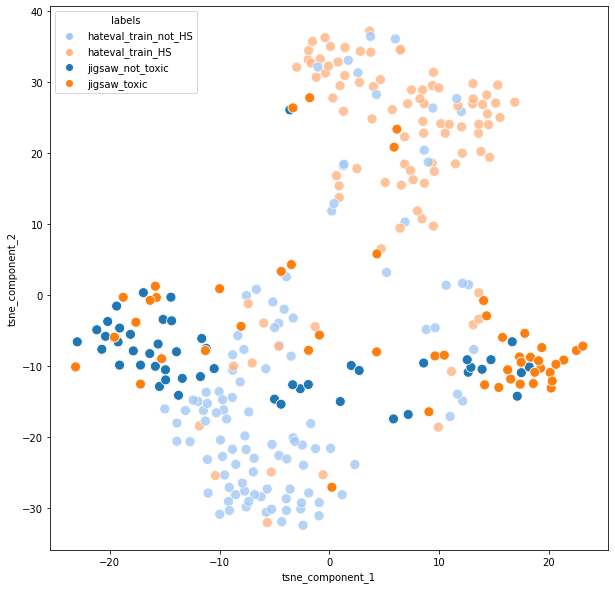

In [249]:
plt.figure(figsize=(10,10))
ax1 = sns.scatterplot(x='tsne_component_1', y='tsne_component_2', data=df1[:200],  hue='labels',
                palette=sns.color_palette("pastel",2), legend="full", alpha=0.8, s=100)

sns.scatterplot(x='tsne_component_1', y='tsne_component_2', data=df1[200:],  hue='labels',
                palette=sns.color_palette("tab10",2), legend="full", alpha=1, s=100)

### Toxic Spans data preprocessing

In [265]:
tsp_comment = pd.read_csv("toxic_spans/comments.csv")
tsp_span = pd.read_csv("toxic_spans/spans.csv")
tsp_ann = pd.read_csv("toxic_spans/annotations.csv")

In [266]:
tsp_ann = tsp_ann[["annotation", "comment_id", "all toxic", "not toxic"]]
joined = pd.merge(tsp_span, tsp_ann, how="left", on="annotation")

In [274]:
joined

,annotation,type,start,end,comment_id,all toxic,not toxic
0,0,Insult,133,139,5167187,False,False
1,1,Insult,84,92,5167187,False,False
2,1,Insult,118,124,5167187,False,False
3,1,Insult,126,131,5167187,False,False
4,1,Insult,133,147,5167187,False,False
...,...,...,...,...,...,...,...
46779,59756,Profane/Obscene,68,72,6209917,False,False
46780,59757,Profane/Obscene,68,72,6209917,False,False
46781,59758,Profane/Obscene,68,72,6209917,False,False
46782,59762,Profane/Obscene,68,72,6209917,False,False


In [294]:
joined_deduped = joined[["start", "end", "comment_id"]].drop_duplicates()
joined_deduped

,start,end,comment_id
0,133,139,5167187
1,84,92,5167187
2,118,124,5167187
3,126,131,5167187
4,133,147,5167187
...,...,...,...
46620,31,36,6209917
46622,0,78,6209917
46677,48,78,6209917
46758,73,78,6209917


In [295]:
tsp_comment

,comment_id,comment_text
0,239607,Yet call out all Muslims for the acts of a few...
1,239612,This bitch is nuts. Who would read a book by a...
2,240311,You're an idiot.
3,240400,"Nincompoop, that's a nice one! I'm partial to ..."
4,240461,testing purposes: \n\nyou are an idiot and i c...
...,...,...
16095,6333139,"Ah, the small minded, short sighted incompeten..."
16096,6333364,"For some of these demonic possessed brats, a s..."
16097,6333372,Butts was stupid enough to lay out the charade...
16098,6333662,This dirtbag is no Marine; he's a sadistic ter...


In [315]:
#replace toxic span with special token
censor_token = "<c>"
annotated = joined_deduped["comment_id"].unique()

original_text = []
censored_text = []
co = 0
for record in tsp_comment.itertuples():
    if record[1] not in annotated:
        pass
    else:
        text = record[2]
        original_text.append(text)
        
        t_span_df = joined_deduped[joined_deduped["comment_id"]==record[1]]
        t_spans = []
        for span in t_span_df.itertuples():
            t_spans.append((span[1], span[2]))
        t_spans.sort(reverse=True)
        #print("before:", t_spans)
        if len(t_spans) == 1:
            text = text[:t_spans[0][0]] + "<c>" + text[t_spans[0][1]:]
        else:
            #use only the longest span if overlap
            for s in t_spans:
                s_inx = t_spans.index(s)
                if s_inx != len(t_spans)-1:
                    for i in range(s_inx+1, len(t_spans)):
                        if s[1] == t_spans[i][1]:
                            t_spans.remove(s)
                            break
                if s_inx != 0:
                    if s[0] == t_spans[s_inx-1][0]:
                        try: 
                            t_spans.remove(s)
                        except:
                            continue
            #print("after:", t_spans)
            for span in t_spans:
                text = text[:span[0]] + "<c>" + text[span[1]:]
                
        censored_text.append(text)

In [317]:
print(len(original_text), len(censored_text))

15499 15499


In [320]:
#export the processed dataset
processed_data = pd.DataFrame()
processed_data["original"] = original_text
processed_data["censored"] = censored_text

processed_data.to_csv("toxic_span_text_pairs.csv", index=False)